# 01 – Dataset Kaggle (maior): treino e inferência YOLO

Este notebook usa o **dataset maior**: Kaggle **“Software Architecture Dataset”** (~33 GB). O objetivo é o mesmo do notebook 00: treinar um detector YOLO em diagramas de arquitetura e usá-lo para **detectar componentes** (ícones de serviços, setas de fluxo). Ao final, é possível **comparar** o desempenho deste modelo (treinado no dataset maior) com o do notebook 00 (Roboflow, dataset menor) para ver se o dataset maior se comporta melhor.

**Dataset deste notebook:** Kaggle “Software Architecture Dataset” (carlosrian/software-architecture-dataset) — tamanho aproximado ~33 GB. Download: na raiz do projeto execute `make download-dataset-kaggle`; os dados ficam em **notebooks/dataset/kaggle/** (requer Kaggle API: `pip install kaggle` e credenciais em `~/.kaggle/kaggle.json` ou `KAGGLE_USERNAME`/`KAGGLE_KEY` em `configs/.env`).

**Fluxo (igual ao 00, com caminhos Kaggle):**  
1. Ambiente e dados — `DATA_DIR` = `notebooks/dataset/kaggle`; `OUTPUTS_DIR` = `notebooks/outputs_kaggle`.  
2. Visualização das anotações.  
3. Treino — pesos em `notebooks/outputs_kaggle/train/weights/best.pt`.  
4. Curvas de loss (`results.csv` em `outputs_kaggle/train/`).  
5. Inferência e visualização.  
6. Imagens externas (opcional).  
7. Testes do modelo (mapeamento de classes, amostra train).  
8. **Comparativo** — indicações para comparar com o notebook 00 (Roboflow).

## Passo 1 – Ambiente e dados (dataset Kaggle)

**Objetivo:** Definir a raiz do projeto, a pasta do **dataset Kaggle** (`notebooks/dataset/kaggle/`) e as saídas em `notebooks/outputs_kaggle/`.

**Estrutura esperada:** `dataset/kaggle/raw/` (VOC PNG+XML) e `dataset/kaggle/` (train/, valid/, data.yaml em YOLO). Se tiver só raw/, rode `make convert-voc-to-yolo`.

In [46]:
# Imports
from pathlib import Path
import yaml
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from ultralytics import YOLO
from dotenv import load_dotenv

In [47]:
# Raiz do projeto; dataset Kaggle na raiz; saídas em notebooks/outputs_kaggle
for candidate in [Path.cwd(), Path.cwd().parent]:
    env_file = candidate / "configs" / ".env"
    if env_file.exists():
        load_dotenv(env_file)
        PROJECT_ROOT = candidate
        break
else:
    PROJECT_ROOT = Path.cwd()
    while PROJECT_ROOT != PROJECT_ROOT.parent and not (PROJECT_ROOT / "notebooks").exists():
        PROJECT_ROOT = PROJECT_ROOT.parent

NOTEBOOKS_DIR = PROJECT_ROOT / "notebooks"
DATA_DIR = NOTEBOOKS_DIR / "dataset" / "kaggle"

# Se data.yaml não estiver na raiz, procurar em subpastas (1 ou 2 níveis) após extrair o ZIP
if DATA_DIR.exists() and not (DATA_DIR / "data.yaml").exists():
    found = None
    for sub in sorted(DATA_DIR.iterdir()):
        if not sub.is_dir():
            continue
        if (sub / "data.yaml").exists():
            found = sub
            break
        for sub2 in sorted(sub.iterdir()) if sub.is_dir() else []:
            if sub2.is_dir() and (sub2 / "data.yaml").exists():
                found = sub2
                break
        if found is not None:
            break
    if found is not None:
        DATA_DIR = found

OUTPUTS_DIR = NOTEBOOKS_DIR / "outputs_kaggle"
ASSETS_DIR = NOTEBOOKS_DIR / "assets"
IMAGES_DIR = DATA_DIR / "train" / "images"
LABELS_DIR = DATA_DIR / "train" / "labels"
print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_DIR:", DATA_DIR)
print("OUTPUTS_DIR:", OUTPUTS_DIR)
print("Dataset existe:", DATA_DIR.exists(), "| data.yaml:", (DATA_DIR / "data.yaml").exists(), "| train/images:", IMAGES_DIR.exists())
if not (DATA_DIR / "data.yaml").exists():
    print("AVISO: Dataset não encontrado. Na raiz do projeto execute: make download-dataset-kaggle ou make convert-voc-to-yolo (dados em notebooks/dataset/kaggle/)")

PROJECT_ROOT: /home/lucas-biason/Projetos/Projetos/Ativos/threat-modeling-ai
DATA_DIR: /home/lucas-biason/Projetos/Projetos/Ativos/threat-modeling-ai/notebooks/dataset/kaggle
OUTPUTS_DIR: /home/lucas-biason/Projetos/Projetos/Ativos/threat-modeling-ai/notebooks/outputs_kaggle
Dataset existe: True | data.yaml: True | train/images: True


**Classes e tamanho do dataset (Kaggle)**

Leitura do `data.yaml` e contagem de imagens/labels em `train`, igual ao notebook 00.

In [48]:
# Carregar classes do data.yaml (só roda se o dataset tiver sido baixado)
data_yaml = DATA_DIR / "data.yaml"
if not data_yaml.exists():
    print("data.yaml não encontrado em:", data_yaml)
    print("Na raiz do projeto execute: make download-dataset-kaggle")
    print("(Requer: pip install kaggle e credenciais em ~/.kaggle/kaggle.json ou KAGGLE_USERNAME/KAGGLE_KEY em configs/.env)")
    CLASSES = []
else:
    with open(data_yaml) as f:
        data_cfg = yaml.safe_load(f)
    CLASSES = data_cfg.get("names", [])
    if isinstance(CLASSES, dict):
        CLASSES = list(CLASSES.values()) if CLASSES else []
    print("Total de classes:", len(CLASSES))
    print("Primeiras 15 classes:", CLASSES[:15])

Total de classes: 85
Primeiras 15 classes: ['aws_amazon_api_gateway', 'aws_amazon_cloudfront', 'aws_amazon_cloudwatch', 'aws_amazon_dynamodb', 'aws_amazon_ec2', 'aws_amazon_ec2_auto_scaling', 'aws_amazon_elastic_block_store', 'aws_amazon_elastic_container_service', 'aws_amazon_elastic_kubernetes_service', 'aws_amazon_elasticache', 'aws_amazon_rds', 'aws_amazon_redshift', 'aws_amazon_route_53', 'aws_amazon_simple_notification_service', 'aws_amazon_simple_queue_service']


In [49]:
# Contar imagens e labels em train
def analisar_base(images_dir, labels_dir):
    imgs = list(images_dir.glob("*.jpg")) + list(images_dir.glob("*.png")) if images_dir.exists() else []
    lbls = list(labels_dir.glob("*.txt")) if labels_dir.exists() else []
    return len(imgs), len(lbls)

n_imgs, n_lbls = analisar_base(IMAGES_DIR, LABELS_DIR)
print(f"dataset/kaggle/train: {n_imgs} imagens, {n_lbls} labels")
if n_imgs == 0:
    print("AVISO: Nenhuma imagem. Rode: make download-dataset-kaggle")

dataset/kaggle/train: 1021 imagens, 1021 labels


## Passo 2 – Visualização das anotações (ground truth)

Uma imagem do train com bounding boxes lidas do arquivo de labels YOLO correspondente.

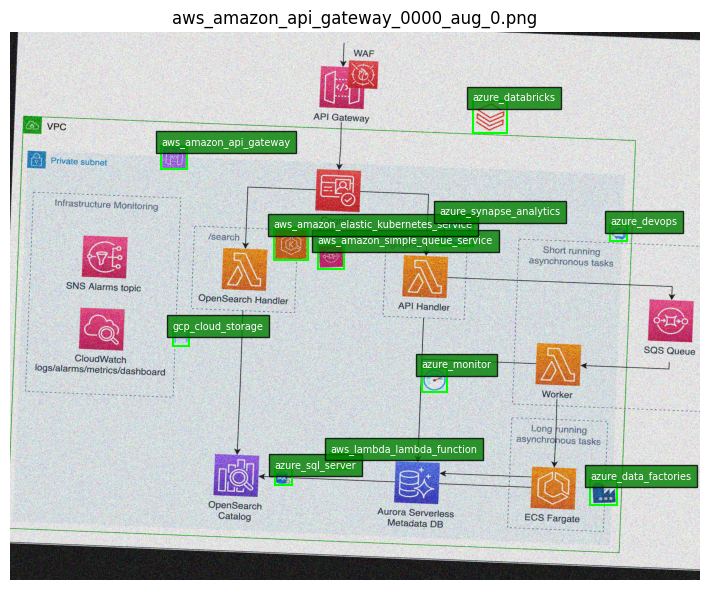

In [50]:
# Uma imagem do train com bounding boxes do arquivo de labels
imagens = sorted([f for f in IMAGES_DIR.iterdir() if f.suffix.lower() in (".jpg", ".png")]) if IMAGES_DIR.exists() else []
if not imagens:
    print("Nenhuma imagem em train/images. Rode: make download-dataset-kaggle")
else:
    img_path = imagens[0]
    lbl_path = LABELS_DIR / (img_path.stem + ".txt")
    img = np.array(Image.open(img_path).convert("RGB"))
    h, w = img.shape[:2]
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    ax.imshow(img)
    if lbl_path.exists():
        with open(lbl_path) as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 5:
                    cls_id = int(parts[0])
                    x_c, y_c, bw, bh = map(float, parts[1:5])
                    x1 = int((x_c - bw / 2) * w)
                    y1 = int((y_c - bh / 2) * h)
                    x2 = int((x_c + bw / 2) * w)
                    y2 = int((y_c + bh / 2) * h)
                    nome = CLASSES[cls_id] if cls_id < len(CLASSES) else str(cls_id)
                    ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor="lime", linewidth=1.5))
                    ax.text(x1, y1 - 4, nome, color="white", fontsize=7, bbox=dict(facecolor="green", alpha=0.8))
    ax.set_title(img_path.name)
    ax.axis("off")
    plt.tight_layout()
    plt.show()

## Passo 3 – Treino (executar via script)

O treino **trava o kernel**. Use: `python notebooks/train_yolo.py --dataset kaggle --epochs 200`. Saída em `outputs/mvp_kaggle/weights/best.pt`.

In [51]:
# Treinamento: execute no terminal (trava o kernel)
DATA_YAML = DATA_DIR / "data.yaml"
print('Execute no terminal:')
print('  python notebooks/train_yolo.py --dataset kaggle --epochs 200 --imgsz 416 --batch 2')
print('Pesos em notebooks/outputs/mvp_kaggle/weights/best.pt')

Execute no terminal:
  python notebooks/train_yolo.py --dataset kaggle --epochs 200 --imgsz 416 --batch 2
Pesos em notebooks/outputs/mvp_kaggle/weights/best.pt


## Passo 4 – Curvas de loss

Leitura de `notebooks/outputs/mvp_kaggle/results.csv` (gerado pelo `train_yolo.py`) e plot das curvas de loss.

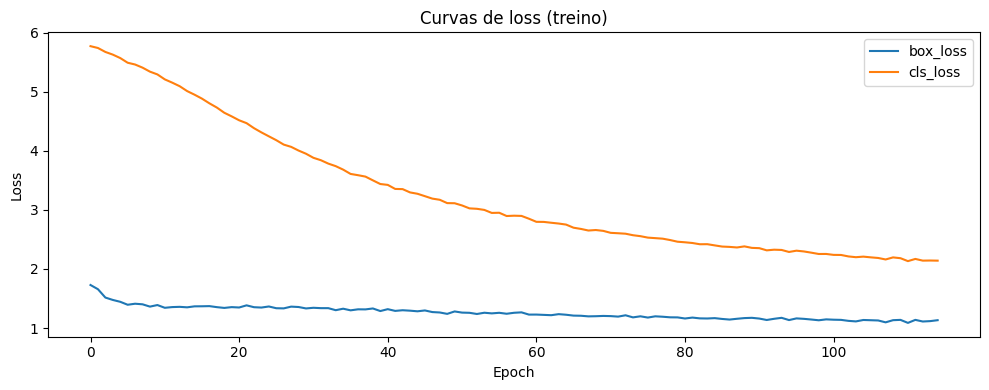

In [52]:
# Plot curvas de loss (igual ao notebook 00: gráfico único com box_loss e cls_loss)
import pandas as pd
results_csv = NOTEBOOKS_DIR / "outputs" / "mvp_kaggle" / "results.csv"
if not results_csv.exists():
    results_csv = NOTEBOOKS_DIR / "outputs" / "mvp_kaggle" / "train" / "results.csv"
if results_csv.exists():
    df = pd.read_csv(results_csv)
    df.columns = df.columns.str.strip()
    fig, ax = plt.subplots(1, 1, figsize=(10, 4))
    if "train/box_loss" in df.columns:
        ax.plot(df["train/box_loss"], label="box_loss")
    if "train/cls_loss" in df.columns:
        ax.plot(df["train/cls_loss"], label="cls_loss")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend()
    ax.set_title("Curvas de loss (treino)")
    plt.tight_layout()
    plt.show()
else:
    print("results.csv não encontrado. Execute o Passo 3 (treino) e verifique outputs/mvp_kaggle/.")

## Passo 5 – Inferência e visualização

Função `analisar_componentes_e_ligacoes` que carrega `best.pt` de **outputs/mvp_kaggle** e devolve componentes e ligações. Os testes usam as **mesmas imagens** do notebook 00 (Roboflow): `diagram01.png` e `diagram02.png` em `notebooks/assets/`, para comparar os modelos em condições idênticas.

In [53]:
def analisar_componentes_e_ligacoes(path_imagem, weights_path=None, model=None, conf_min=0.25, excluir_classes=None):
    path_imagem = Path(path_imagem)
    if not path_imagem.exists():
        return {"componentes": [], "ligacoes": [], "erro": f"Arquivo não encontrado: {path_imagem}"}
    if model is None:
        if weights_path is None:
            for p in [
                NOTEBOOKS_DIR / "outputs" / "mvp_kaggle" / "train" / "weights" / "best.pt",
                NOTEBOOKS_DIR / "outputs" / "mvp_kaggle" / "weights" / "best.pt",
                OUTPUTS_DIR / "train" / "weights" / "best.pt",
                PROJECT_ROOT / "runs" / "detect" / "train" / "weights" / "best.pt",
            ]:
                if p.exists():
                    weights_path = p
                    break
        if weights_path is None or not Path(weights_path).exists():
            return {"componentes": [], "ligacoes": [], "erro": "Modelo não encontrado. Execute o Passo 3 (treino)."}
        model = YOLO(str(weights_path))
    results = model.predict(str(path_imagem), conf=conf_min, verbose=False)
    excluir = set(excluir_classes) if excluir_classes else set()
    componentes = []
    ligacoes = []
    for r in results:
        if r.boxes is None:
            continue
        names = r.names
        if isinstance(names, list):
            names = {i: str(names[i]) for i in range(len(names))}
        else:
            names = names or {}
        for box in r.boxes:
            cls_id = int(box.cls[0])
            conf = float(box.conf[0])
            xyxy = box.xyxy[0].tolist()
            classe = names.get(cls_id, f"class_{cls_id}")
            if classe in excluir:
                continue
            componentes.append({"classe": classe, "confianca": conf, "bbox": xyxy})
            if classe == "fluxo_seta":
                ligacoes.append({"classe": classe, "confianca": conf, "bbox": xyxy})
    return {"componentes": componentes, "ligacoes": ligacoes}

  diagram01.png: 0 componentes, 0 ligações


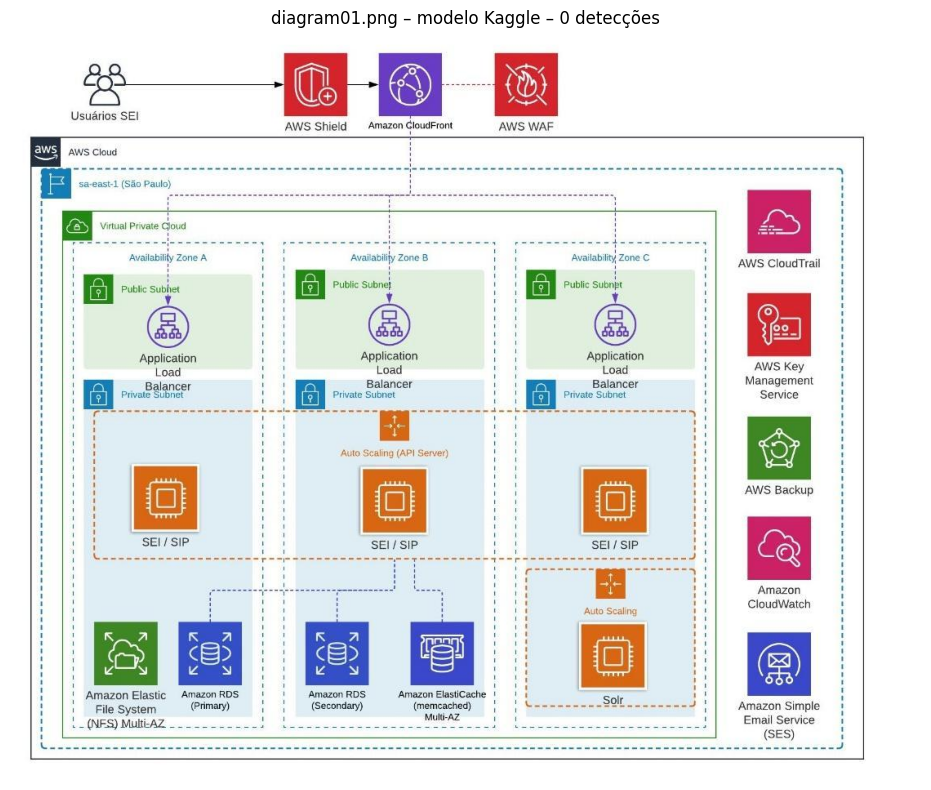

  diagram02.png: 0 componentes, 0 ligações


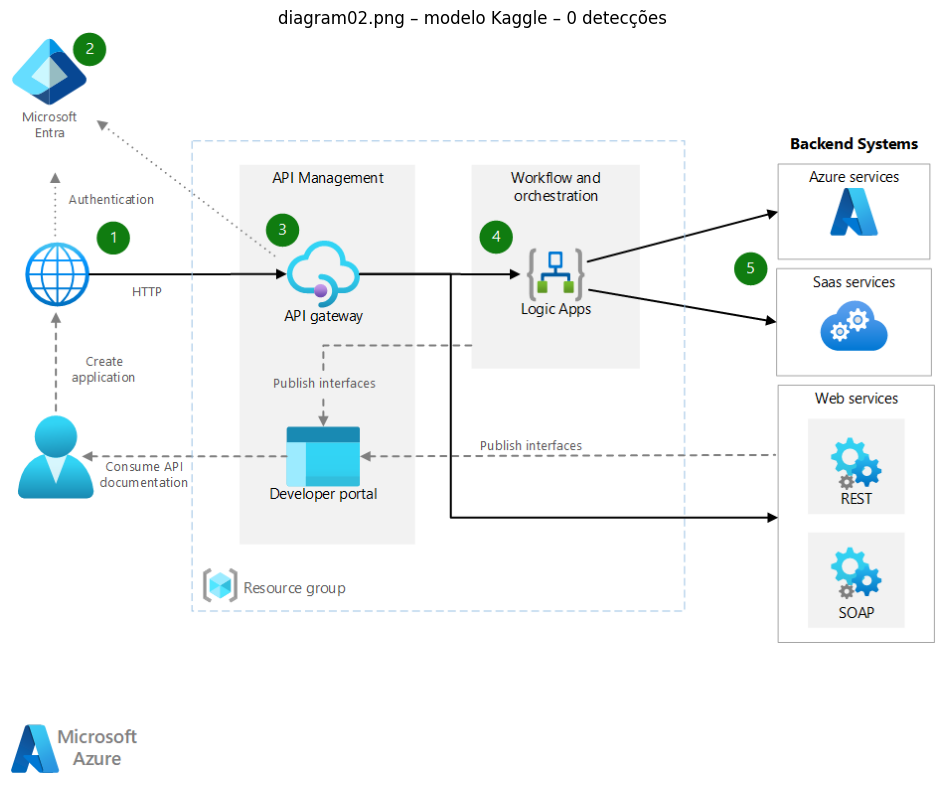

In [54]:
# Testes em diagram01.png e diagram02.png (mesmas imagens do notebook 00 Roboflow)
for name in ["diagram01.png", "diagram02.png"]:
    path = ASSETS_DIR / name
    if not path.exists():
        print(f"  {name}: arquivo não encontrado em {ASSETS_DIR}")
        continue
    out = analisar_componentes_e_ligacoes(path)
    if out.get("erro"):
        print(f"  {name}: {out['erro']}")
        continue
    comp, lig = out["componentes"], out["ligacoes"]
    print(f"  {name}: {len(comp)} componentes, {len(lig)} ligações")
    # Visualizar detecções (igual ao notebook 00)
    img_array = np.array(Image.open(path).convert("RGB"))
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax.imshow(img_array)
    for c in comp:
        x1, y1, x2, y2 = c["bbox"]
        ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor="lime", linewidth=2))
        ax.text(x1, y1 - 5, f"{c['classe']} {c['confianca']:.2f}", color="white", fontsize=8, bbox=dict(facecolor="green", alpha=0.7))
    ax.axis("off")
    ax.set_title(f"{name} – modelo Kaggle – {len(comp)} detecções")
    plt.tight_layout()
    plt.show()